## Analysis of Temperature data - 1975 to 2017

### Our Assumption : Are Average Global Temperatures are rising since 1975?

#### Null Hypothesis - Temperatures are not rising since 1975

The key question we are trying to answer is 
- is Temperature rising sine 1975? 
- What is its replationship with time? 
- if so by how much has it risen
- is statistically supported (p-value)

### Analysis Process & Steps

#### Data file used and Preparation before Analysis
- We start with clean temperature .csv file ( ex., NaN_Replaced_Temps.csv)
- Data loaded onto dataframe using pandas
- Reconfirm that no missing values are present. If present, fill it with row-wise mean before analysis
- Reshape the data from columnwise monthly values to row-wise monthly values
- Add a Date column to assist in time-series plotting

#### Data Grouping
- The prepared data from step above is grouped into two groups. 
    - Group 1: All country level monthly values are summarized at Global level - Yearly and Monthly
    - Group 2: All data is rolled up and summarised at Global level - Yearly
    
#### Exploratory analysis
- Create inital plots to study 
    - the trend of temperature against time, 
    - spread of temperature across the mean
    
#### Statistical Analysis of Trend
- Regression line fit
    - Calculate the moving average mean (12 month window) of temperature from 1975 to 2017
    - Use linear regression (using scipy.stats.lineregress()) and 
        - Calculate Slope, Intercept, r-Value, p-Value and Standard error
    - Plot time-series regression plot of the Temperature averages against time

- ANNOVA to compare 4 independent year groups
    - Group years into 4 bins (1975 - 1985, 1986 - 1996, 1997 - 2007, 2008 - 2017)
    - Perform an ANNOVA on the 4 year groups to conclude that means of the group are significantly different and increasing



In [1]:
# Interactive mapping
%matplotlib inline

### Key packages required
This  analysis depends on usage of 
- data manipulation - pandas and numpy
- plotting using matplotlib, seaborn
- statistical analysis using scipy.stats 

In [2]:
# Import all required dependencies
import csv
import pandas as pd
import numpy as np
import os
from datetime import datetime
import calendar

import matplotlib.pyplot as plt
import matplotlib as mpl

import seaborn as sns

from scipy.stats import linregress

import scipy.stats as stats

#from spread import variance, standard_deviation, zipped_z_scores

import warnings
warnings.filterwarnings('ignore')

# Change the print display
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))
    

### Global constants and initialization throughout the notebook

In [48]:
# Global declarations
data_path = "..\data"

#dataFile = "AvgTempCYear_1.csv"
dataFile = "NaN_Replaced_Temps.csv"

#Output folders
result_dir = "..\output"
image_dir = "..\images"

# Plot Style to use
mpl.style.use('seaborn')
sns.set_style("darkgrid")
sns.set(font_scale=1.2)
color_spread = ['#0000FF','#00CCFF','#CCFFFF','#FFCC00','#FF9900','#FF6600']

## Preparing data for analysis

### Step 1: Load data to dataframe

- Cleaned temperature data is loaded from \data folder
- data is loaded onto temperature dataframe using read_csv() method.
- sample output printed to check if the load was successful

In [122]:
#read data file
tempDF = pd.read_csv(os.path.join(data_path, dataFile))

tempDF = tempDF[(tempDF['Year'] >= 1975) & (tempDF['Year'] <= 2017)]

tempDF.head()

,Country,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,ALGERIA,1975,8.9,10.3,12.1,16.4,20.7,23.8,28.5,27.8,24.7,18.9,12.8,10.9
1,ALGERIA,1976,8.6,10.6,11.3,15.8,19.7,24.9,27.5,25.0,24.2,19.0,11.7,11.1
2,ALGERIA,1977,11.0,12.4,14.8,16.9,20.0,23.0,28.7,26.0,24.0,19.4,14.0,11.7
3,ALGERIA,1978,9.1,13.1,13.8,16.9,20.0,25.1,28.1,27.8,24.8,17.8,12.6,12.9
4,ALGERIA,1979,13.0,12.1,14.4,15.0,21.0,26.5,29.3,29.2,23.8,20.0,11.5,10.2


### Step 2 - Reconfirm that data has no missing values

Check again to see if any values are missing. 

If missing, fix it by using means from each row.

Else all is good to go!


In [123]:
#check for missing values
if(tempDF.isnull().values.sum() != 0 ):
    # few data is missing, fix it before you proceed
    print(f"#### Dataframe has missing values. Total missing values are {tempDF.isnull().values.sum()}")
    printmd("#### ___________________________________________________________________")
    printmd("#### Fixing the missing values with rowMeans")
    rowMeans = tempDF[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']].mean(axis = 1)
    tempDF = tempDF.apply(lambda r: r.fillna(rowMeans[r.index]))
    printmd("#### All Good!!! No missing values")
else:
    printmd("#### All Good!!! No missing values")
    

#### All Good!!! No missing values

### Step 3: Reshape data using melt() 

Reshape the data and move month values from columns to row

This is needed to determine moving average of the temperature data


In [124]:
# Before reshaping
printmd("### Before Reshaping the data.........")
tempDF.head()

### Before Reshaping the data.........

,Country,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,ALGERIA,1975,8.9,10.3,12.1,16.4,20.7,23.8,28.5,27.8,24.7,18.9,12.8,10.9
1,ALGERIA,1976,8.6,10.6,11.3,15.8,19.7,24.9,27.5,25.0,24.2,19.0,11.7,11.1
2,ALGERIA,1977,11.0,12.4,14.8,16.9,20.0,23.0,28.7,26.0,24.0,19.4,14.0,11.7
3,ALGERIA,1978,9.1,13.1,13.8,16.9,20.0,25.1,28.1,27.8,24.8,17.8,12.6,12.9
4,ALGERIA,1979,13.0,12.1,14.4,15.0,21.0,26.5,29.3,29.2,23.8,20.0,11.5,10.2


In [125]:
# Reshape Temp data, such that months are in rows and data col is added
# USE melt() to change the column-wise months into row-wse data

temp_flatDF = pd.melt(tempDF, id_vars =['Country','Year'], var_name = 'Month', value_name = "Monthly_Temp")

printmd("### After Reshaping the data..............")
temp_flatDF.head()

### After Reshaping the data..............

,Country,Year,Month,Monthly_Temp
0,ALGERIA,1975,Jan,8.9
1,ALGERIA,1976,Jan,8.6
2,ALGERIA,1977,Jan,11.0
3,ALGERIA,1978,Jan,9.1
4,ALGERIA,1979,Jan,13.0


### Step 4 : Add Date Column

Add the date column to the dataframe. 

In [126]:
#Convert month names to month number
month_num = dict((v,k) for k,v in enumerate(calendar.month_abbr))

temp_flatDF['Month_Num'] = temp_flatDF['Month'].apply(lambda r: month_num[r] )

# Add Date column, example 01-Jan-1975
temp_flatDF['Date'] = temp_flatDF['Year'].astype(str)+'-'+temp_flatDF['Month'].astype(str)+'-01'
temp_flatDF['Date'] = temp_flatDF['Date'].apply(lambda r: datetime.strptime(r , '%Y-%b-%d'))

temp_flatDF.sort_values(by = ['Year','Month_Num'])

printmd("#### Dataframe before start of analysis....")
temp_flatDF.head()

#### Dataframe before start of analysis....

,Country,Year,Month,Monthly_Temp,Month_Num,Date
0,ALGERIA,1975,Jan,8.9,1,1975-01-01
1,ALGERIA,1976,Jan,8.6,1,1976-01-01
2,ALGERIA,1977,Jan,11.0,1,1977-01-01
3,ALGERIA,1978,Jan,9.1,1,1978-01-01
4,ALGERIA,1979,Jan,13.0,1,1979-01-01


## START ANALYSIS

### Roll up averages to global level for temp 

#### Group 1: Rollup country monthly averages to global yearly and monthly averages

In [127]:
# Group by year and month and aggregate values by mean()

temp_GDF_YM = temp_flatDF.groupby(['Year','Date','Month_Num']).agg(np.mean)

temp_GDF_YM.reset_index(inplace = True)


temp_GDF_YM.sort_values(by = ['Year','Month_Num'])

temp_GDF_YM.head()


,Year,Date,Month_Num,Monthly_Temp
0,1975,1975-01-01,1,12.086667
1,1975,1975-02-01,2,12.323333
2,1975,1975-03-01,3,14.375417
3,1975,1975-04-01,4,16.607500
4,1975,1975-05-01,5,18.815833


#### Group 2: Rollup country monthly averages to global  averages by year

In [128]:
# Group by year aggregate values by mean()

temp_GDF_Y = temp_flatDF[['Year','Monthly_Temp']].groupby(['Year']).agg(np.mean)

temp_GDF_Y.reset_index(inplace = True)
 
temp_GDF_Y.head()

,Year,Monthly_Temp
0,1975,16.578437
1,1976,16.183403
2,1977,16.634201
3,1978,16.402431
4,1979,16.594826


In [129]:
temp_GDF_Y.describe()

,Year,Monthly_Temp
count,43.000000,43.000000
mean,1996.000000,17.124162
std,12.556539,0.450257
min,1975.000000,16.183403
25%,1985.500000,16.698454
50%,1996.000000,17.259494
75%,2006.500000,17.463717
max,2017.000000,17.923102


In [130]:
temp_quartiles = list(temp_GDF_Y.describe()['Monthly_Temp'].iloc[4:8].values)
temp_quartiles.append(0)
temp_quartiles.sort()
temp_quartiles

[0,
 16.6984537037037,
 17.259494212962938,
 17.46371662808641,
 17.923101851851833]

In [131]:
temp_quartiles = list(temp_GDF_Y.describe()['Monthly_Temp'].iloc[4:8].values)
temp_quartiles.append(0)
temp_quartiles.sort()

grp_names = ['25th Quartile','50th Quartile', '75th Quartile', 'Max Value']

temp_GDF_Y['TempGrps'] = pd.cut(temp_GDF_Y['Monthly_Temp'], temp_quartiles, labels = grp_names)

temp_GDF_Y.head()

,Year,Monthly_Temp,TempGrps
0,1975,16.578437,25th Quartile
1,1976,16.183403,25th Quartile
2,1977,16.634201,25th Quartile
3,1978,16.402431,25th Quartile
4,1979,16.594826,25th Quartile


In [132]:
# Calculate Standard Deviation
mean_temp = temp_GDF_Y['MEAN'] = temp_GDF_Y['Monthly_Temp'].mean()
std_temp = temp_GDF_Y['STD'] = temp_GDF_Y['Monthly_Temp'].std()

temp_GDF_Y.head()

,Year,Monthly_Temp,TempGrps,MEAN,STD
0,1975,16.578437,25th Quartile,17.124162,0.450257
1,1976,16.183403,25th Quartile,17.124162,0.450257
2,1977,16.634201,25th Quartile,17.124162,0.450257
3,1978,16.402431,25th Quartile,17.124162,0.450257
4,1979,16.594826,25th Quartile,17.124162,0.450257


In [133]:
# CAlculate z_score for each value
temp_GDF_Y['Z_SCORE'] = temp_GDF_Y['Monthly_Temp'].apply(lambda v : ((v - mean_temp)/std_temp) )

### Calculate monthly moving average value for all years on 12 month rolling window

In [138]:
temp_movAvg_DF = temp_GDF_YM[['Date','Monthly_Temp']].rolling(window = 12, on = 'Date').mean()

#temp_movAvg_DF.set_index('Date', inplace = True)

#get year
temp_movAvg_DF['Year'] = temp_movAvg_DF['Date'].apply(lambda r : r.year)

# get time delta in months so we can how temperature varies
temp_movAvg_DF.set_index('Date', inplace = True)
timedel = (temp_movAvg_DF.index - temp_movAvg_DF.index[0])

temp_movAvg_DF['days'] = timedel.days


temp_movAvg_DF.reset_index(inplace = True)
temp_movAvg_DF.head()


,Date,Monthly_Temp,Year,days
0,1975-01-01,NaN,1975,0
1,1975-02-01,NaN,1975,31
2,1975-03-01,NaN,1975,59
3,1975-04-01,NaN,1975,90
4,1975-05-01,NaN,1975,120


## Exploratory Analysis

### Create simple plot of Average Yearly Temperature by year - to visualise temp trend

In [139]:
# Plot a moving average of temperature since 1975

x_axis1 = temp_movAvg_DF['Date'].apply(lambda d : mpl.dates.date2num(d))
#x_axis1 = temp_movAvg_DF['days']
y_axis1 = temp_movAvg_DF['Monthly_Temp'] 

#mask is boolean values that tells plot to use or ignore values
mask = ~np.isnan(y_axis1)

x_axis1 = x_axis1[mask]
y_axis1 = y_axis1[mask]


### Average Temperature change month on month from 1975 to 2017 

This indicates that temperature is rising over years though by small degree linearly

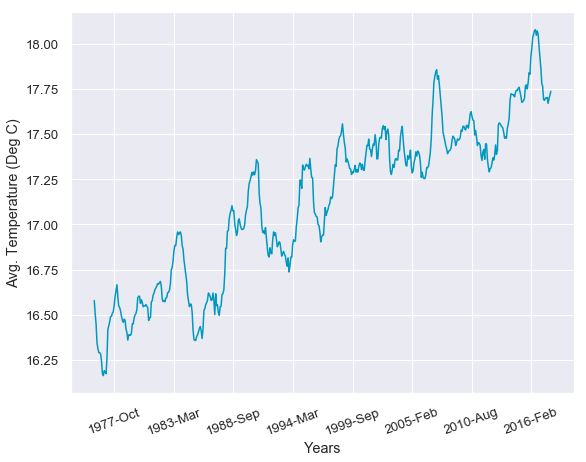

In [157]:
# # Plot a simple timeseries plot to show temperature trend

printmd(f"### Average Temperature change month on month from {temp_movAvg_DF['Year'].min()} to {temp_movAvg_DF['Year'].max()} ")
printmd("This indicates that temperature is rising over years though by small degree linearly")
g = sns.lineplot(x_axis1,y_axis1, color = '#0098BF')

ax1 = g.axes
ax1.set_xticklabels(ax.get_xticks())

labels = [item.get_text() for item in ax.get_xticklabels()]
ax1.set_xticklabels(labels, rotation = 20)

ax1.set(xlabel='Years', ylabel='Avg. Temperature (Deg C)')

fig = plt.gcf()
fig.set_size_inches( 9, 7)

plt.savefig(os.path.join(image_dir,"AvgTemp_Change_rolling.png"))

plt.show()


### PLot showing Z-Score representation temperature over years

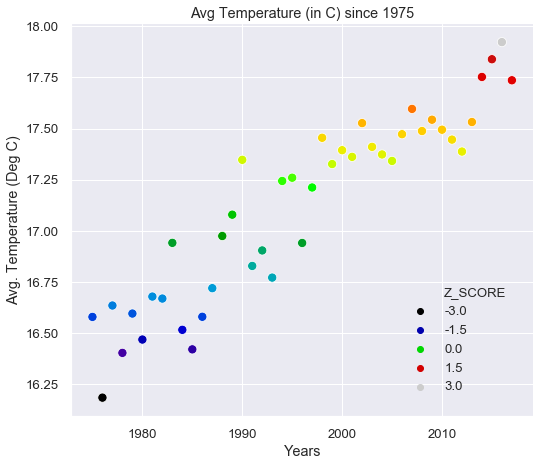

In [158]:
printmd("### PLot showing Z-Score representation temperature over years")

simpPlt_ax = sns.relplot( 'Year','Monthly_Temp', data = temp_GDF_Y,  \
                         hue = 'Z_SCORE', palette = 'nipy_spectral', s = 85)

simpPlt_ax.set(xlabel='Years', ylabel='Avg. Temperature (Deg C)', title = "Avg Temperature (in C) since 1975")

simpPlt_ax.fig.get_children()[-1].set_bbox_to_anchor((0.6,0.15,0.0,0.2))

fig = plt.gcf()
fig.set_size_inches( 12, 7)
#plt.legend(loc='upper left')

plt.savefig(os.path.join(image_dir,"TempvsTimePlt.png"))

plt.show()

### Distribution of temperature

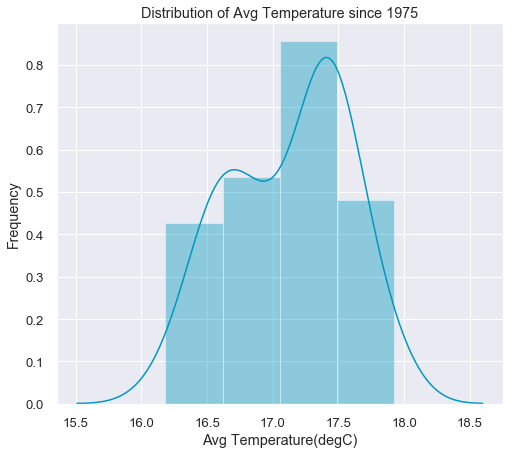

In [135]:
distPlt_Temp = sns.distplot(temp_GDF_Y['Monthly_Temp'], color = "#0098BF")

distPlt_Temp.set(xlabel='Avg Temperature(degC)', ylabel='Frequency', title = "Distribution of Avg Temperature since 1975")

fig = plt.gcf()
fig.set_size_inches( 8, 7)

plt.savefig(os.path.join(image_dir,"TempDist.png"))

plt.show()

### Regression Analysis on Temp - Monthly Moving Average

In [136]:
#
# Set line
x_axis = temp_GDF_Y['Year']
y_axis = temp_GDF_Y['Monthly_Temp'] 
(slope, intercept, r_value, p_value, std_err) = linregress(x_axis, y_axis)
fit = slope * x_axis + intercept
printmd(f"#### Slope of the regression line is {slope}")
printmd(f"#### p-Value of the regression line is {p_value}")

#### Slope of the regression line is 0.03326803472152286

#### p-Value of the regression line is 3.7341400868911146e-19

### Plot showing a Linear Regression Model Fit for Average Temperature

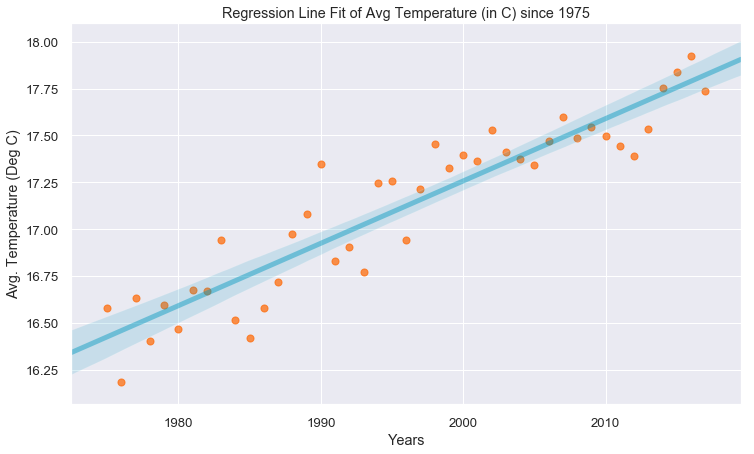

In [183]:
# create seaborn plot for regression

printmd("### Plot showing a Linear Regression Model Fit for Average Temperature")

regPlot_ax = sns.regplot(x="Year", y="Monthly_Temp", data=temp_GDF_Y, ci = 95, x_estimator=np.mean,\
                        scatter_kws = {"color":"#FF6600","alpha":0.7}, line_kws = {"color":"#0098BF","alpha":0.45,"lw":5})

regPlot_ax.set(xlabel='Years', ylabel='Avg. Temperature (Deg C)', \
               title = "Regression Line Fit of Avg Temperature (in C) since 1975")

fig = plt.gcf()
fig.set_size_inches( 12, 7)

plt.savefig(os.path.join(image_dir,"AvgTemp_regressFit.png"))

plt.show()


### ANNOVA  Test to prove "Surface temp has risen more 0.5 degC since 1975"

4 groups are created 1975 - 1985, 1986 - 1996, 1997 - 2007, 2008 - 2017

In [141]:
# Create four Bins of Temp over years
bins = [1974, 1986, 1997, 2008,  2018]

# Create the names for the four bins
group_names = ["1975 - 1985", "1986 - 1996", "1997 - 2007", "2008 - 2017"]

In [142]:
temp_GDF_Y['TempGrps'] = pd.cut(temp_GDF_Y['Year'], bins, labels = group_names)

temp_GDF_Y.head()

,Year,Monthly_Temp,TempGrps,MEAN,STD,Z_SCORE
0,1975,16.578437,1975 - 1985,17.124162,0.450257,-1.212028
1,1976,16.183403,1975 - 1985,17.124162,0.450257,-2.089382
2,1977,16.634201,1975 - 1985,17.124162,0.450257,-1.088179
3,1978,16.402431,1975 - 1985,17.124162,0.450257,-1.602931
4,1979,16.594826,1975 - 1985,17.124162,0.450257,-1.175629


### Box Plot of Avg. Surface Temperature (deg.C) for Year Group from 1975 to 2017

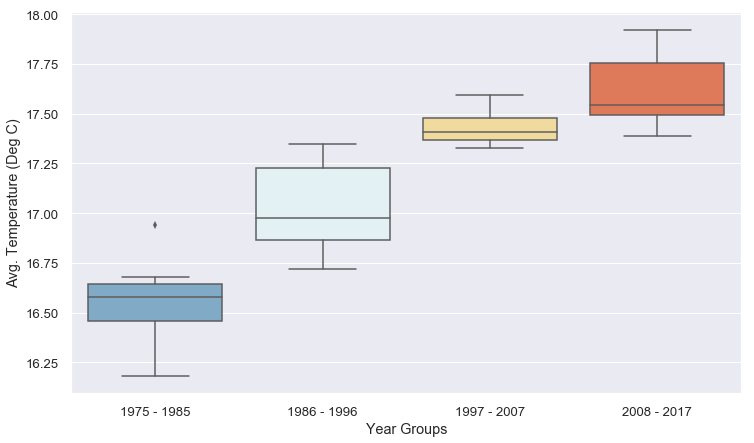

In [185]:
# Create a box whisker plot to see how the groups have been trendng
printmd(f"### Box Plot of Avg. Surface Temperature (deg.C) for Year Group from {min(x_axis)} to {max(x_axis)}")
box_ax = sns.boxplot(x="TempGrps", y="Monthly_Temp", data=temp_GDF_Y, palette='RdYlBu_r')

box_ax.set(xlabel='Year Groups', ylabel='Avg. Temperature (Deg C)')

fig = plt.gcf()
fig.set_size_inches( 12, 7)

plt.savefig(os.path.join(image_dir,"AvgTemp_boxPlot.png"))

plt.show()

### Create groups for ANNOVA analysis

In [144]:
# Extract individual groups
group1 = temp_GDF_Y[temp_GDF_Y["TempGrps"] == group_names[0]]["Monthly_Temp"]
group2 = temp_GDF_Y[temp_GDF_Y["TempGrps"] == group_names[1]]["Monthly_Temp"]
group3 = temp_GDF_Y[temp_GDF_Y["TempGrps"] == group_names[2]]["Monthly_Temp"]
group4 = temp_GDF_Y[temp_GDF_Y["TempGrps"] == group_names[3]]["Monthly_Temp"]


In [149]:
# Perform the ANOVA
reslt = stats.f_oneway(group1, group2, group3, group4)

reslt

F_onewayResult(statistic=79.5945379265069, pvalue=1.116950400152688e-16)